This notebook is my submission for Titanic Kaggle competition.  It references two good texts on machine learning:
- Hands-On Machine Learning and Deep Learning with Scikit-Learn and TensorFlow by Aurelien Geron
- Machine Learning Mastery by Jason Brownlee

I also found the following websites useful:
- http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
- http://michelleful.github.io/code-blog/2015/06/20/pipelines/

It does not focus on EDA or on achieving a great score.   

The main aim of this notebook to utilise methods that make it easier to change the features selected and to tune the hyperparameters in a efficient way.



In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#allows printing of all data in cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [83]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## 1.0 Investigate Data

In [84]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The attributes have the following meaning:
- **Survived**: the target, 0 means the passenger did not survive, while 1 means he/she survived.
- **Pclass**: passenger class.
- **Name**, Sex, Age: self-explanatory
- **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
- **Parch**: how many children & parents of the passenger aboard the Titanic.
- **Ticket**: ticket id
- **Fare**: price paid (in pounds)
- **Cabin**: passenger's cabin number
- **Embarked**: where the passenger embarked the Titanic

In [51]:
train_data.describe()
train_data['Age'].mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


29.69911764705882

In [52]:
#check the target
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [53]:
#age has 177 missing data values, calculate a mean value and insert
average_age = train_data['Age'].mean()
std_age = train_data['Age'].std()
count_age = train_data['Age'].isnull().sum()

#generate rand numbers between (mean - std) & (mean = std) of length count_age
random_1 = np.random.randint(average_age - std_age, average_age + std_age,size = count_age)
#replace nan values with calculated random values
train_data['Age'][np.isnan(train_data['Age'])] = random_1
#float not needed, convert to integer
train_data['Age'] = train_data['Age'].astype(int)


average_age = test_data['Age'].mean()
std_age = test_data['Age'].std()
count_age = test_data['Age'].isnull().sum()

#generate rand numbers between (mean - std) & (mean = std) of length count_age
random_1 = np.random.randint(average_age - std_age, average_age + std_age,size = count_age)
#replace nan values with calculated random values
test_data['Age'][np.isnan(test_data['Age'])] = random_1
#float not needed, convert to integer
test_data['Age'] = test_data['Age'].astype(int)

In [54]:
train_data['Age'].mean()

29.535353535353536

## 2.0 Process the Data

In [56]:
#Try using using a categorical variable for age
train_data['AgeBucket'] = train_data['Age'] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

test_data['AgeBucket'] = test_data['Age'] // 15 * 15

,Survived
AgeBucket,
0,0.576923
15,0.356784
30,0.373333
45,0.404494
60,0.240000
75,1.000000


In [57]:
#add relatives on board category
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()
train_data.dtypes

test_data["RelativesOnboard"] = test_data["SibSp"] + test_data["Parch"]

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


PassengerId           int64
Survived              int64
Pclass                int64
Name                 object
Sex                  object
Age                   int64
SibSp                 int64
Parch                 int64
Ticket               object
Fare                float64
Cabin                object
Embarked             object
AgeBucket             int64
RelativesOnboard      int64
dtype: object

A method used by Geron to allow efficient pipelining of categorical variables:

In [58]:
#A method taken from stakoverflow that uses encodes categorical features into numeric.  It is similar to get_dummies
#but allows  

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

DataframeSelector to select specific attributes from the DataFrame:

In [59]:
#Use to select specific attributes
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Pipeline for the numerical attributes:

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["SibSp", "Parch", "Fare",'RelativesOnboard'])),
        ("imputer", Imputer(strategy="median")),
        ('Scaler', StandardScaler())
    ])

Imputer for the string categorical columns (the regular Imputer does not work on those):

In [61]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent)

Pipeline for the categorical attributes:

In [62]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked","AgeBucket"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", CategoricalEncoder(encoding='onehot-dense')),
    ])

In [63]:
cat_pipeline.fit_transform(train_data)

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.]])

Join the numerical and categorical pipelines:

In [64]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [65]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[ 0.43279337, -0.47367361, -0.50244517, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.43279337, -0.47367361,  0.78684529, ...,  0.        ,
         0.        ,  0.        ],
       [-0.4745452 , -0.47367361, -0.48885426, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.43279337,  2.00893337, -0.17626324, ...,  0.        ,
         0.        ,  0.        ],
       [-0.4745452 , -0.47367361, -0.04438104, ...,  0.        ,
         0.        ,  0.        ],
       [-0.4745452 , -0.47367361, -0.49237783, ...,  0.        ,
         0.        ,  0.        ]])

Get the labels:

In [66]:
y_train = train_data['Survived']

validation_size = 0.2
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=validation_size, 
                                                                random_state=seed)

In [67]:
X_train.shape
X_test.shape
y_train.shape
y_test.shape

(712, 18)

(179, 18)

(712,)

(179,)

## 3.0 Evaluate non-ensemble Baseline methods  


In [68]:
#evaluation - baselines
num_folds = 10
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s %f %f " % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR 0.803502 0.058415 
LDA 0.813282 0.051009 
KNN 0.816158 0.050253 
CART 0.806338 0.053313 
NB 0.806260 0.047066 
SVM 0.838595 0.058587 


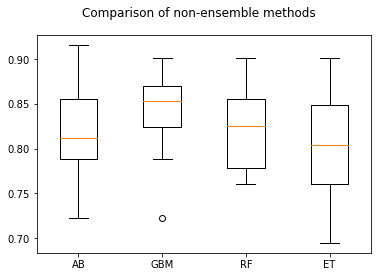

In [85]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Comparison of non-ensemble methods')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

## 3.1 Tune the best non-ensemble methods

In [70]:
neighbors = [1, 3, 5, 7, 9, 15, 19, 21]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.820225 using {'n_neighbors': 21}
0.757022 (0.044951) with: {'n_neighbors': 1}
0.816011 (0.053194) with: {'n_neighbors': 3}
0.816011 (0.050259) with: {'n_neighbors': 5}
0.808989 (0.057731) with: {'n_neighbors': 7}
0.814607 (0.065616) with: {'n_neighbors': 9}
0.814607 (0.055518) with: {'n_neighbors': 15}
0.816011 (0.060990) with: {'n_neighbors': 19}
0.820225 (0.052407) with: {'n_neighbors': 21}


In [71]:
# Tune scaled SVM
c_values = [1,1.3,1.5,1.7]
kernel_values = ['rbf']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.846910 using {'C': 1.3, 'kernel': 'rbf'}
0.838483 (0.058637) with: {'C': 1, 'kernel': 'rbf'}
0.846910 (0.051935) with: {'C': 1.3, 'kernel': 'rbf'}
0.845506 (0.051719) with: {'C': 1.5, 'kernel': 'rbf'}
0.845506 (0.051719) with: {'C': 1.7, 'kernel': 'rbf'}


In [72]:
svm_clf = SVC(C=1.3,kernel='rbf')
svm_clf.fit(X_train,y_train)

SVC(C=1.3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Try on the test data and make submission

In [73]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [74]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
scores.mean()

0.84414375139727249

In [75]:
output = pd.DataFrame({ 'PassengerId' : test_data['PassengerId'], 'Survived': y_pred })

In [76]:
output.to_csv('submission.csv', index=False)

## 4.0 Evaluate ensemble methods


----------Ensemble methods------------
AB: 0.818975 (0.050512)
GBM: 0.841451 (0.051450)
RF: 0.820286 (0.044971)
ET: 0.803521 (0.065643)


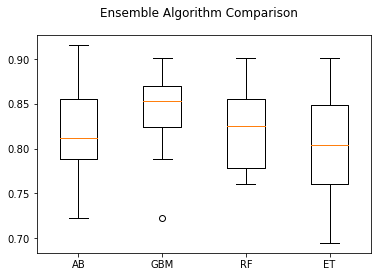

In [77]:
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

## 4.1 Evaluate Ensemble method

In [78]:
# Tune scaled GBM
num_trees = [10,50,100,150,200,250,300]
#kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(n_estimators=num_trees)
#param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200),'n_estimators':[100,200,300]}                 
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.844101 using {'n_estimators': 150}
0.832865 (0.056389) with: {'n_estimators': 10}
0.841292 (0.052908) with: {'n_estimators': 50}
0.842697 (0.053351) with: {'n_estimators': 100}
0.844101 (0.043619) with: {'n_estimators': 150}
0.837079 (0.053587) with: {'n_estimators': 200}
0.838483 (0.051814) with: {'n_estimators': 250}
0.834270 (0.048520) with: {'n_estimators': 300}


In [79]:
GB_clf = GradientBoostingClassifier(max_depth=9,n_estimators = 150,min_samples_split=400)
GB_clf.fit(X_train,y_train)
X_test = preprocess_pipeline.transform(test_data)
y_pred = GB_clf.predict(X_test)
from sklearn.model_selection import cross_val_score

scores = cross_val_score(GB_clf, X_train, y_train, cv=10)
scores.mean()
output = pd.DataFrame({ 'PassengerId' : test_data['PassengerId'], 'Survived': y_pred })
output.to_csv('submission.csv', index=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=400,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

0.83136876816454297